# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
%matplotlib inline
#Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
#Extracting features and labels from training and testing data
xtrain, ytrain = train['X'],train['y']
xtest, ytest = test['X'], test['y']

print("Training Set shapes", xtrain.shape, ytrain.shape)
print("Test Set shapes", xtest.shape, ytest.shape)

Training Set shapes (32, 32, 3, 73257) (73257, 1)
Test Set shapes (32, 32, 3, 26032) (26032, 1)


In [4]:
xtrain, ytrain = xtrain.transpose((3,0,1,2)), ytrain[:,0]
xtest, ytest = xtest.transpose((3,0,1,2)), ytest[:,0]

print("Training Set shapes", xtrain.shape, ytrain.shape)
print("Test Set shapes", xtest.shape, ytest.shape)

Training Set shapes (73257, 32, 32, 3) (73257,)
Test Set shapes (26032, 32, 32, 3) (26032,)


### Ploting training data examples
Selecting a sample of images and corresponding labels from the dataset (at least 10), and displaying them in a figure

In [5]:
def plot_data(images, labels):
    fig, axes = plt.subplots(2, 6)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[i])

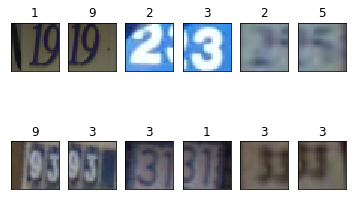

In [32]:
plot_data(xtrain, ytrain)

### Ploting test data examples

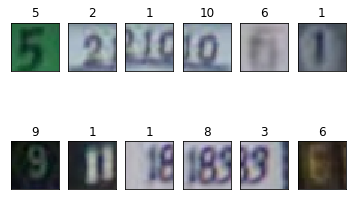

In [33]:
plot_data(xtest, ytest)

### Converting into greyscale
Converting the training and test images to grayscale by taking the average across all colour channels for each pixel

In [6]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [7]:
xtrain = rgb2gray(xtrain).astype(np.float32)
xtest = rgb2gray(xtest).astype(np.float32)

In [8]:
print("greyscale train shape" , xtrain.shape)
print("greyscale test shape" , xtest.shape)

greyscale train shape (73257, 32, 32, 1)
greyscale test shape (26032, 32, 32, 1)


In [9]:
def plot_greydata(images, labels):
    fig, axes = plt.subplots(2, 6)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:,:,0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[i])

training data in greyscale


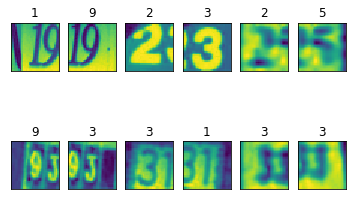

In [49]:
print("training data in greyscale")
plot_greydata(xtrain, ytrain)

test data in greyscale


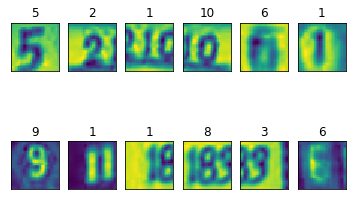

In [50]:
print("test data in greyscale")
plot_greydata(xtest, ytest)

In [10]:
#Normalizing Data
train_mean = np.mean(xtrain, axis=0)
train_std = np.std(xtrain, axis=0)

xtrain = (xtrain - train_mean) / train_std
xtest = (xtest - train_mean)  / train_std

In [11]:
xtrain = xtrain/255
xtest = xtest/255

training data in greyscale


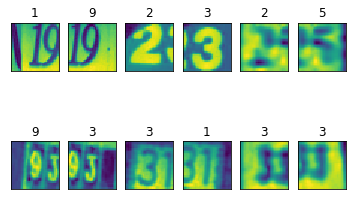

In [55]:
print("training data in greyscale")
plot_greydata(xtrain, ytrain)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras import regularizers 

In [13]:
cnnxtrain = xtrain
cnnxtest = xtest
xtrain = xtrain[..., np.newaxis]
xtest = xtest[..., np.newaxis]

In [94]:
model = Sequential([
    Flatten(input_shape = xtrain[0].shape),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(11, activation = 'softmax')
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_51 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_54 (Dense)             (None, 11)                363       
Total params: 675,019
Trainable params: 675,019
Non-trainable params: 0
_______________________________________________

In [102]:
def get_checkpoint_every_epoch():
    check = ModelCheckpoint(filepath = 'checkpoints_every_epoch/checkpoint_{epoch:03d}' , save_freq="epoch",save_weights_only=True)
    return check

def get_checkpoint_best_only():
    check = ModelCheckpoint(filepath = 'checkpoints_best_only/checkpoint' , monitor="val_accuracy",mode = 'max', save_weights_only=True, save_best_only=True)
    return check
checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
callbacks = [checkpoint_every_epoch, checkpoint_best_only]

In [103]:
history= model.fit(xtrain, ytrain, epochs =30,batch_size = 256, validation_split =0.15, callbacks=callbacks )

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 25s 402us/sample - loss: 0.8546 - accuracy: 0.7364 - val_loss: 0.8360 - val_accuracy: 0.7424
Epoch 2/30
62268/62268 [==============================] - 25s 402us/sample - loss: 0.7602 - accuracy: 0.7694 - val_loss: 0.7705 - val_accuracy: 0.7656
Epoch 3/30
62268/62268 [==============================] - 25s 396us/sample - loss: 0.6962 - accuracy: 0.7887 - val_loss: 0.7335 - val_accuracy: 0.7773
Epoch 4/30
62268/62268 [==============================] - 23s 370us/sample - loss: 0.6444 - accuracy: 0.8033 - val_loss: 0.6704 - val_accuracy: 0.7957
Epoch 5/30
62268/62268 [==============================] - 23s 369us/sample - loss: 0.6062 - accuracy: 0.8145 - val_loss: 0.6462 - val_accuracy: 0.8049
Epoch 6/30
62268/62268 [==============================] - 23s 367us/sample - loss: 0.5707 - accuracy: 0.8253 - val_loss: 0.6236 - val_accuracy: 0.8114
Epoch 7/30
62268/62268 [====================

In [96]:
frame = pd.DataFrame(history.history)

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

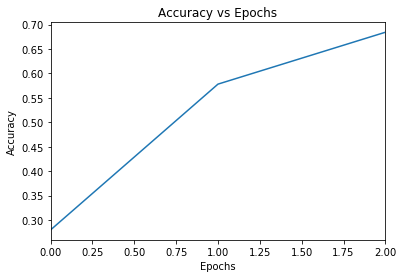

In [97]:
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

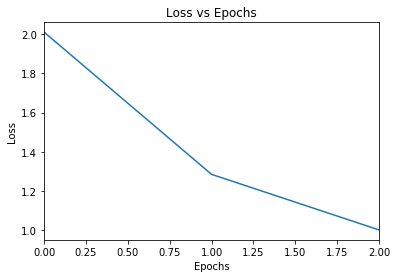

In [98]:
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

In [99]:
def evaluate_model(model, scaled_test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(scaled_test_images,test_labels, verbose =2)
    return (test_loss, test_accuracy)

test_loss, test_accuracy = evaluate_model(model, xtest, ytest)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

26032/1 - 6s - loss: 0.8540 - accuracy: 0.6781
Test loss: 1.0478021356688736
Test accuracy: 0.6780501008033752


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, input_shape=cnnxtrain[0].shape, activation='relu'),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    Conv2D(filters=8, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=8),
    Flatten(name='flatten'),
    Dense(32, activation='relu'),
    Dense(11, activation='softmax')
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2336      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                363       
Total params: 4,019
Trainable params: 4,019
Non-trainable params: 0
____________________________________________________

In [16]:
def get_early_stopping():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode = 'max')
    return early_stopping
def get_checkpoint_best_only():
    check = ModelCheckpoint(filepath = 'cnncheckpoints_best_only/checkpoint' , monitor="val_accuracy",mode = 'max', save_weights_only=True, save_best_only=True)
    return check

In [21]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

callbacks = [checkpoint_best_only, early_stopping]
history= model.fit(cnnxtrain, ytrain, epochs =3,batch_size = 256, validation_split =0.15, callbacks=callbacks )

Train on 62268 samples, validate on 10989 samples
Epoch 1/3
62268/62268 [==============================] - 201s 3ms/sample - loss: 2.2650 - accuracy: 0.1804 - val_loss: 2.2389 - val_accuracy: 0.1881
Epoch 2/3
62268/62268 [==============================] - 199s 3ms/sample - loss: 2.2379 - accuracy: 0.1894 - val_loss: 2.2394 - val_accuracy: 0.1881
Epoch 3/3
62268/62268 [==============================] - 198s 3ms/sample - loss: 2.2376 - accuracy: 0.1894 - val_loss: 2.2381 - val_accuracy: 0.1881


In [22]:
frame = pd.DataFrame(history.history)

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

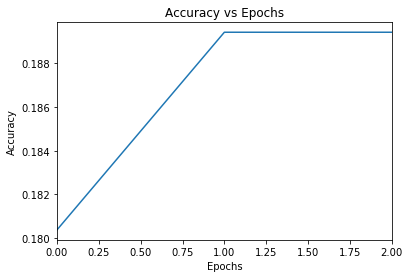

In [23]:
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

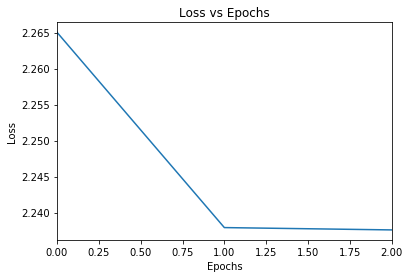

In [24]:
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

In [25]:
def evaluate_model(model, scaled_test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(scaled_test_images,test_labels, verbose =2)
    return (test_loss, test_accuracy)

test_loss, test_accuracy = evaluate_model(model, cnnxtest, ytest)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

26032/1 - 30s - loss: 2.2282 - accuracy: 0.1959
Test loss: 2.225929153280604
Test accuracy: 0.19587430357933044


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [29]:
def plotPrediction(model, data, label):
    
    num_test_images = cnnxtest.shape[0]
    random_inx = np.random.choice(num_test_images, 4)
    random_test_images = data[random_inx, ...]
    random_test_labels = label[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")

    plt.show()

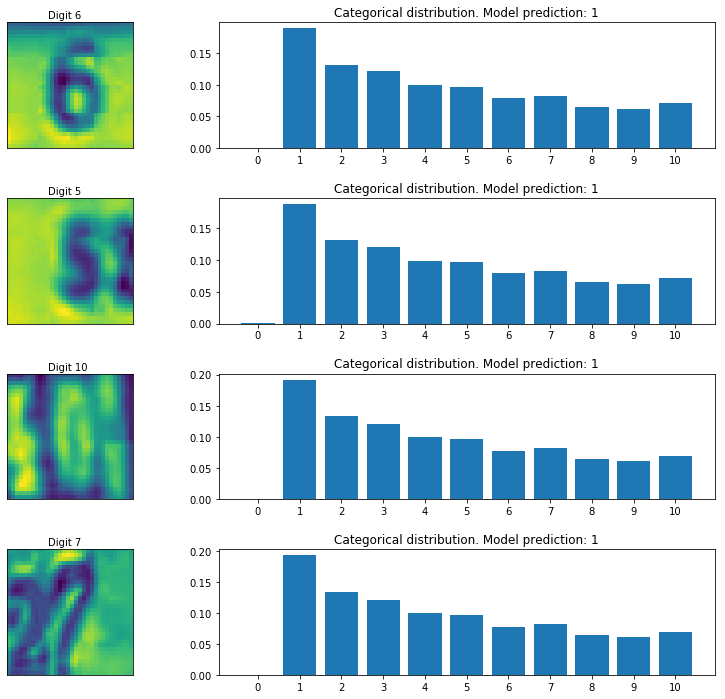

In [30]:
plotPrediction(model, cnnxtest, ytest)

In [ ]:
plotPrediction(model, xtest, ytest)